In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.io import mmread
from scipy.sparse import csr_matrix
import pickle as pkl
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

import gc

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
#import seaborn as sns

import scib_metrics as sm
import sys
import os
sys.path.append('/'.join(os.getcwd().split('/')[:-1]+['eval','cleaned','']))
#from metrics import ilisi,asw_batch

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

# Define the path to the directory you want to change to
new_directory = '/scratch365/eaboelno/cVAE_analysis/sysVI/'

# Use os.chdir() to change the working directory
os.chdir(new_directory)

In [2]:
adata = sc.read_h5ad('./adata_all_mergedHVG_CAPS_updateSYS.h5ad')
adata

AnnData object with n_obs × n_vars = 433583 × 2904
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'human_gene_id', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name'
    layers: 'counts', 'log1p_norm'

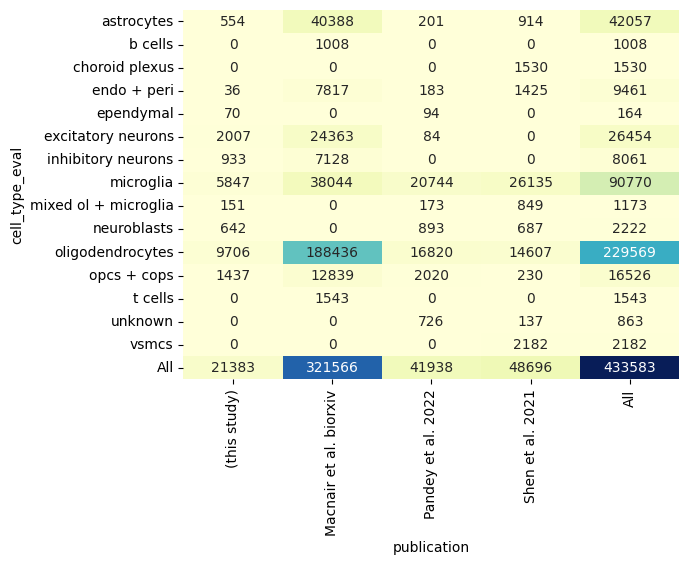

In [4]:
crosstab_df = pd.crosstab(adata.obs.cell_type_eval, adata.obs.publication, margins=True)

# Create the heatmap with integer annotations
sb.heatmap(crosstab_df, cmap="YlGnBu", annot=True, fmt="d", cbar=False)

# Show the heatmap
plt.show()

In [5]:
system_counts = adata.obs['system'].value_counts()

# Create a DataFrame to display the counts
system_counts_df = pd.DataFrame({'System': system_counts.index, 'Count': system_counts.values})
system_counts_df

,System,Count
0,2,321566
1,1,90634
2,0,21383


# Non-integrated embedding

In [6]:
adata.obs

,sample_id,publication,sample_id_anon,individual_id_anon,replicate,treatment,condition,tissue,time,batch,lesion_type,sample_source,diagnosis,n_genes_by_counts,total_counts,pct_counts_mt,pct_counts_ribo,s_score,g2m_score,phase,type_fine,type_broad,cluster_zoom,exclude_pseudobulk,seq_pool,sex,age_at_death,smoker,cause_of_death,years_w_ms,pmi_minutes,age_scale,age_cat,pmi_cat,pmi_cat2,cell_cycle_diff,cell_type_eval,library_type,sample_type,organism,system
GTATTTCGTCCACATA-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,3806.0,14894.0,0.013428,0.093998,-0.160523,-0.120577,G1,TBD,excitatory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,-0.039946,excitatory neurons,10X 3p kit v3.1,sn,mouse,0
ATACCTTGTCGACGCT-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,3755.0,14716.0,0.000000,0.176678,-0.137565,-0.107280,G1,TBD,inhibitory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,-0.030285,inhibitory neurons,10X 3p kit v3.1,sn,mouse,0
TCAAGACGTGCTGCAC-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,4396.0,14823.0,0.026985,0.155164,-0.147916,-0.150035,G1,TBD,excitatory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,0.002119,excitatory neurons,10X 3p kit v3.1,sn,mouse,0
AGTACTGTCAAGTAAG-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,4583.0,14604.0,0.020542,0.212271,-0.132352,-0.172023,G1,TBD,excitatory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,0.039672,excitatory neurons,10X 3p kit v3.1,sn,mouse,0
TCCCAGTTCCGATGCG-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,3839.0,14266.0,0.028039,0.203281,-0.134222,-0.118009,G1,TBD,inhibitory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,-0.016213,inhibitory neurons,10X 3p kit v3.1,sn,mouse,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ind102-Sample4:TTTGTTGAGCGACTGA-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,CAL,Amsterdam BB,SPMS,842.0,1227.0,5.207486,0.437056,0.006362,-0.053391,S,Oligo_B,Oligodendrocytes,oligo_opc-cl01,False,Pool 1,M,64,non-smoker,terminal phase ms; spastic ms,34.0,450.0,0.301502181578831,inbetween,6H_to_12H,up_to_12H,0.059753,oligodendrocytes,10X 3p kit v3.3,sn,human,2
Ind102-Sample4:TTTGTTGAGTAGCTCT-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,CAL,Amsterdam BB,SPMS,641.0,1060.0,7.627119,0.139768,-0.048246,-0.086150,G1,Micro_C,Microglia,microglia-cl03,False,Pool 1,M,64,non-smoker,terminal phase ms; spastic ms,34.0,450.0,0.301502181578831,inbetween,6H_to_12H,up_to_12H,0.037903,microglia,10X 3p kit v3.3,sn,human,2
Ind102-Sample4:TTTGTTGCAGACGATG-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,CAL,Amsterdam BB,SPMS,580.0,820.0,7.299270,0.322318,-0.084481,-0.032177,G1,Micro_B,Microglia,microglia-cl02,False,Pool 1,M,64,non-smoker,terminal phase ms; spastic ms,34.0,450.0,0.301502181578831,inbetween,6H_to_12H,up_to_12H,-0.052304,microglia,10X 3p kit v3.3,sn,human,2
Ind102-Sample4:TTTGTTGCATACAGAA-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,CAL,Amsterdam BB,SPMS,1146.0,1899.0,5.891636,0.383352,0.025758,0.049047,G2M,Oligo_E,Oligodendrocytes,oligo_opc-cl03,False,Pool 1,M,64,non-smoker,terminal 

In [7]:
# Non-integrated embedding
n_pcs=15
cells_eval=np.random.RandomState(seed=0).permutation(adata.obs_names)[:100000]
adata_temp=adata[cells_eval,:].copy()
sc.pp.scale(adata_temp)
sc.pp.pca(adata_temp, n_comps=n_pcs)
sc.pp.neighbors(adata_temp, use_rep='X_pca')
sc.tl.umap(adata_temp)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

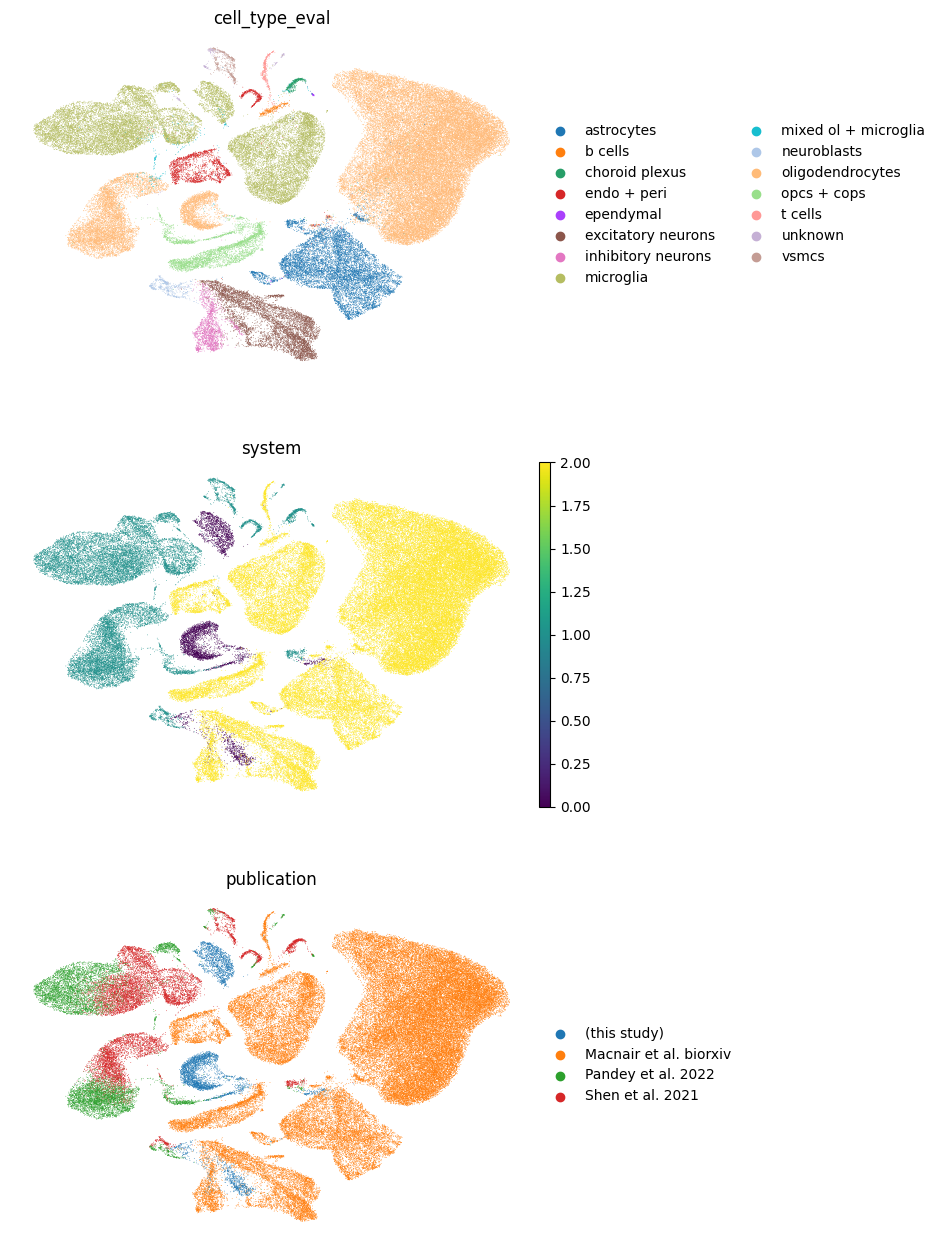

In [8]:
sc.pl.umap(adata_temp, color=['cell_type_eval', 'system', 'publication'], ncols=1, frameon=False)

In [9]:
# Slimmed down data for saving
adata_embed=sc.AnnData(adata_temp.obsm['X_pca'],obs=adata_temp.obs)
for k in ['pca','neighbors','umap']:
    adata_embed.uns[k]=adata_temp.uns[k]
adata_embed.obsm['X_umap']=adata_temp.obsm['X_umap']
for k in ['distances', 'connectivities']:
    adata_embed.obsp[k]=adata_temp.obsp[k]
display(adata_embed)

AnnData object with n_obs × n_vars = 100000 × 15
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

Text(0.5, 0, 'PCs')

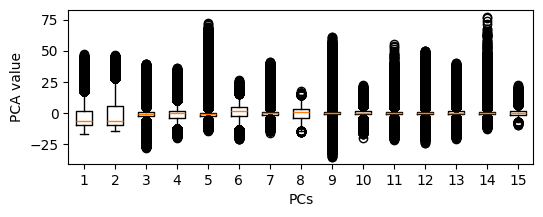

In [10]:
# Check ranges of individual PCs
rcParams['figure.figsize']=(6,2)
_=plt.boxplot(adata_embed.X)
plt.ylabel('PCA value')
plt.xlabel('PCs')

# Moran's I: batch-system and group

In [11]:
# Potential groups to compute Moran's I on (batch-system and group)
cols=pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 120)
display(pd.crosstab(adata.obs.batch,adata.obs.cell_type_eval))
pd.set_option('display.max_rows', cols)

cell_type_eval,astrocytes,b cells,choroid plexus,endo + peri,ependymal,excitatory neurons,inhibitory neurons,microglia,mixed ol + microglia,neuroblasts,oligodendrocytes,opcs + cops,t cells,unknown,vsmcs
batch,,,,,,,,,,,,,,,
1,38,0,0,2,20,982,205,278,24,33,507,325,0,0,0
2,71,0,0,8,23,212,110,775,27,26,698,250,0,0,0
3,63,0,0,7,2,207,197,289,15,203,2777,145,0,0,0
4,54,0,0,4,7,151,97,171,11,172,1579,69,0,0,0
5,80,0,0,7,3,24,150,2363,26,64,762,238,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,298,2,0,72,0,139,104,345,0,0,3980,201,68,0,0
119,2053,50,0,271,0,155,29,859,0,0,1528,123,12,0,0
120,14,1,0,24,0,4,4,27,0,0,481,13,3,0,0


In [12]:
# Filtered groups based on N cells and also remove the doublets
groups=adata.obs.groupby(['cell_type_eval','system','batch']).size()
groups=groups[(groups>=500).values&~groups.index.get_level_values(0).str.contains('\+')]
rows=pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 250)
display(groups)
pd.set_option('display.max_rows', rows)
print('N cell types',groups.index.get_level_values('cell_type_eval').nunique())

/tmp/143724.1.gpu-long/ipykernel_2395080/1990905415.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=adata.obs.groupby(['cell_type_eval','system','batch']).size()


cell_type_eval      system  batch
astrocytes          2       36       1027
                            45        710
                            46       2102
                            48       1262
                            50        603
                            59       1413
                            60        629
                            63        728
                            67        762
                            70       1205
                            75        631
                            81        937
                            82       3932
                            83       2039
                            87       1739
                            92       1280
                            98        716
                            101       974
                            110       532
                            113       881
                            119      2053
choroid plexus      1       21       1162
excitatory neurons  0       1         982


N cell types 7


In [13]:
# Compute Moran's I per group
data=[]
for group in groups.index:
    # Group adata
    print(group)
    adata_sub=adata[
        (adata.obs.cell_type_eval==group[0]).values&\
        (adata.obs.system==group[1]).values&\
        (adata.obs.batch==group[2]).values,:].copy()
    # Remove lowly expr genes before Moran's I computation as they will be less likely relevant
    # As this is done per small cell group within sample+cell type and HVGs there is not many genes (200-500)
    # so all can be used for Moran's I computation
    sc.pp.filter_genes(adata_sub, min_cells=adata_sub.shape[0]*0.1) 
    # Compute embedding of group
    sc.pp.pca(adata_sub, n_comps=15)
    sc.pp.neighbors(adata_sub, n_pcs=15)
    # Compute I
    morans_i=sc.metrics._morans_i._morans_i(
        g=adata_sub.obsp['connectivities'],
        vals=adata_sub.X.T)
    # Save data
    morans_i=pd.DataFrame({'morans_i':morans_i},index=adata_sub.var_names)
    morans_i['group']=group[0]
    morans_i['system']=group[1]
    morans_i['batch']=group[2]
    data.append(morans_i)
data=pd.concat(data,axis=0)

('astrocytes', 2, '36')
('astrocytes', 2, '45')
('astrocytes', 2, '46')
('astrocytes', 2, '48')
('astrocytes', 2, '50')
('astrocytes', 2, '59')
('astrocytes', 2, '60')
('astrocytes', 2, '63')
('astrocytes', 2, '67')
('astrocytes', 2, '70')
('astrocytes', 2, '75')
('astrocytes', 2, '81')
('astrocytes', 2, '82')
('astrocytes', 2, '83')
('astrocytes', 2, '87')
('astrocytes', 2, '92')
('astrocytes', 2, '98')
('astrocytes', 2, '101')
('astrocytes', 2, '110')
('astrocytes', 2, '113')
('astrocytes', 2, '119')
('choroid plexus', 1, '21')
('excitatory neurons', 0, '1')
('excitatory neurons', 2, '53')
('excitatory neurons', 2, '54')
('excitatory neurons', 2, '58')
('excitatory neurons', 2, '74')
('excitatory neurons', 2, '76')
('excitatory neurons', 2, '77')
('excitatory neurons', 2, '81')
('excitatory neurons', 2, '82')
('excitatory neurons', 2, '83')
('excitatory neurons', 2, '87')
('excitatory neurons', 2, '97')
('excitatory neurons', 2, '101')
('excitatory neurons', 2, '115')
('inhibitory ne

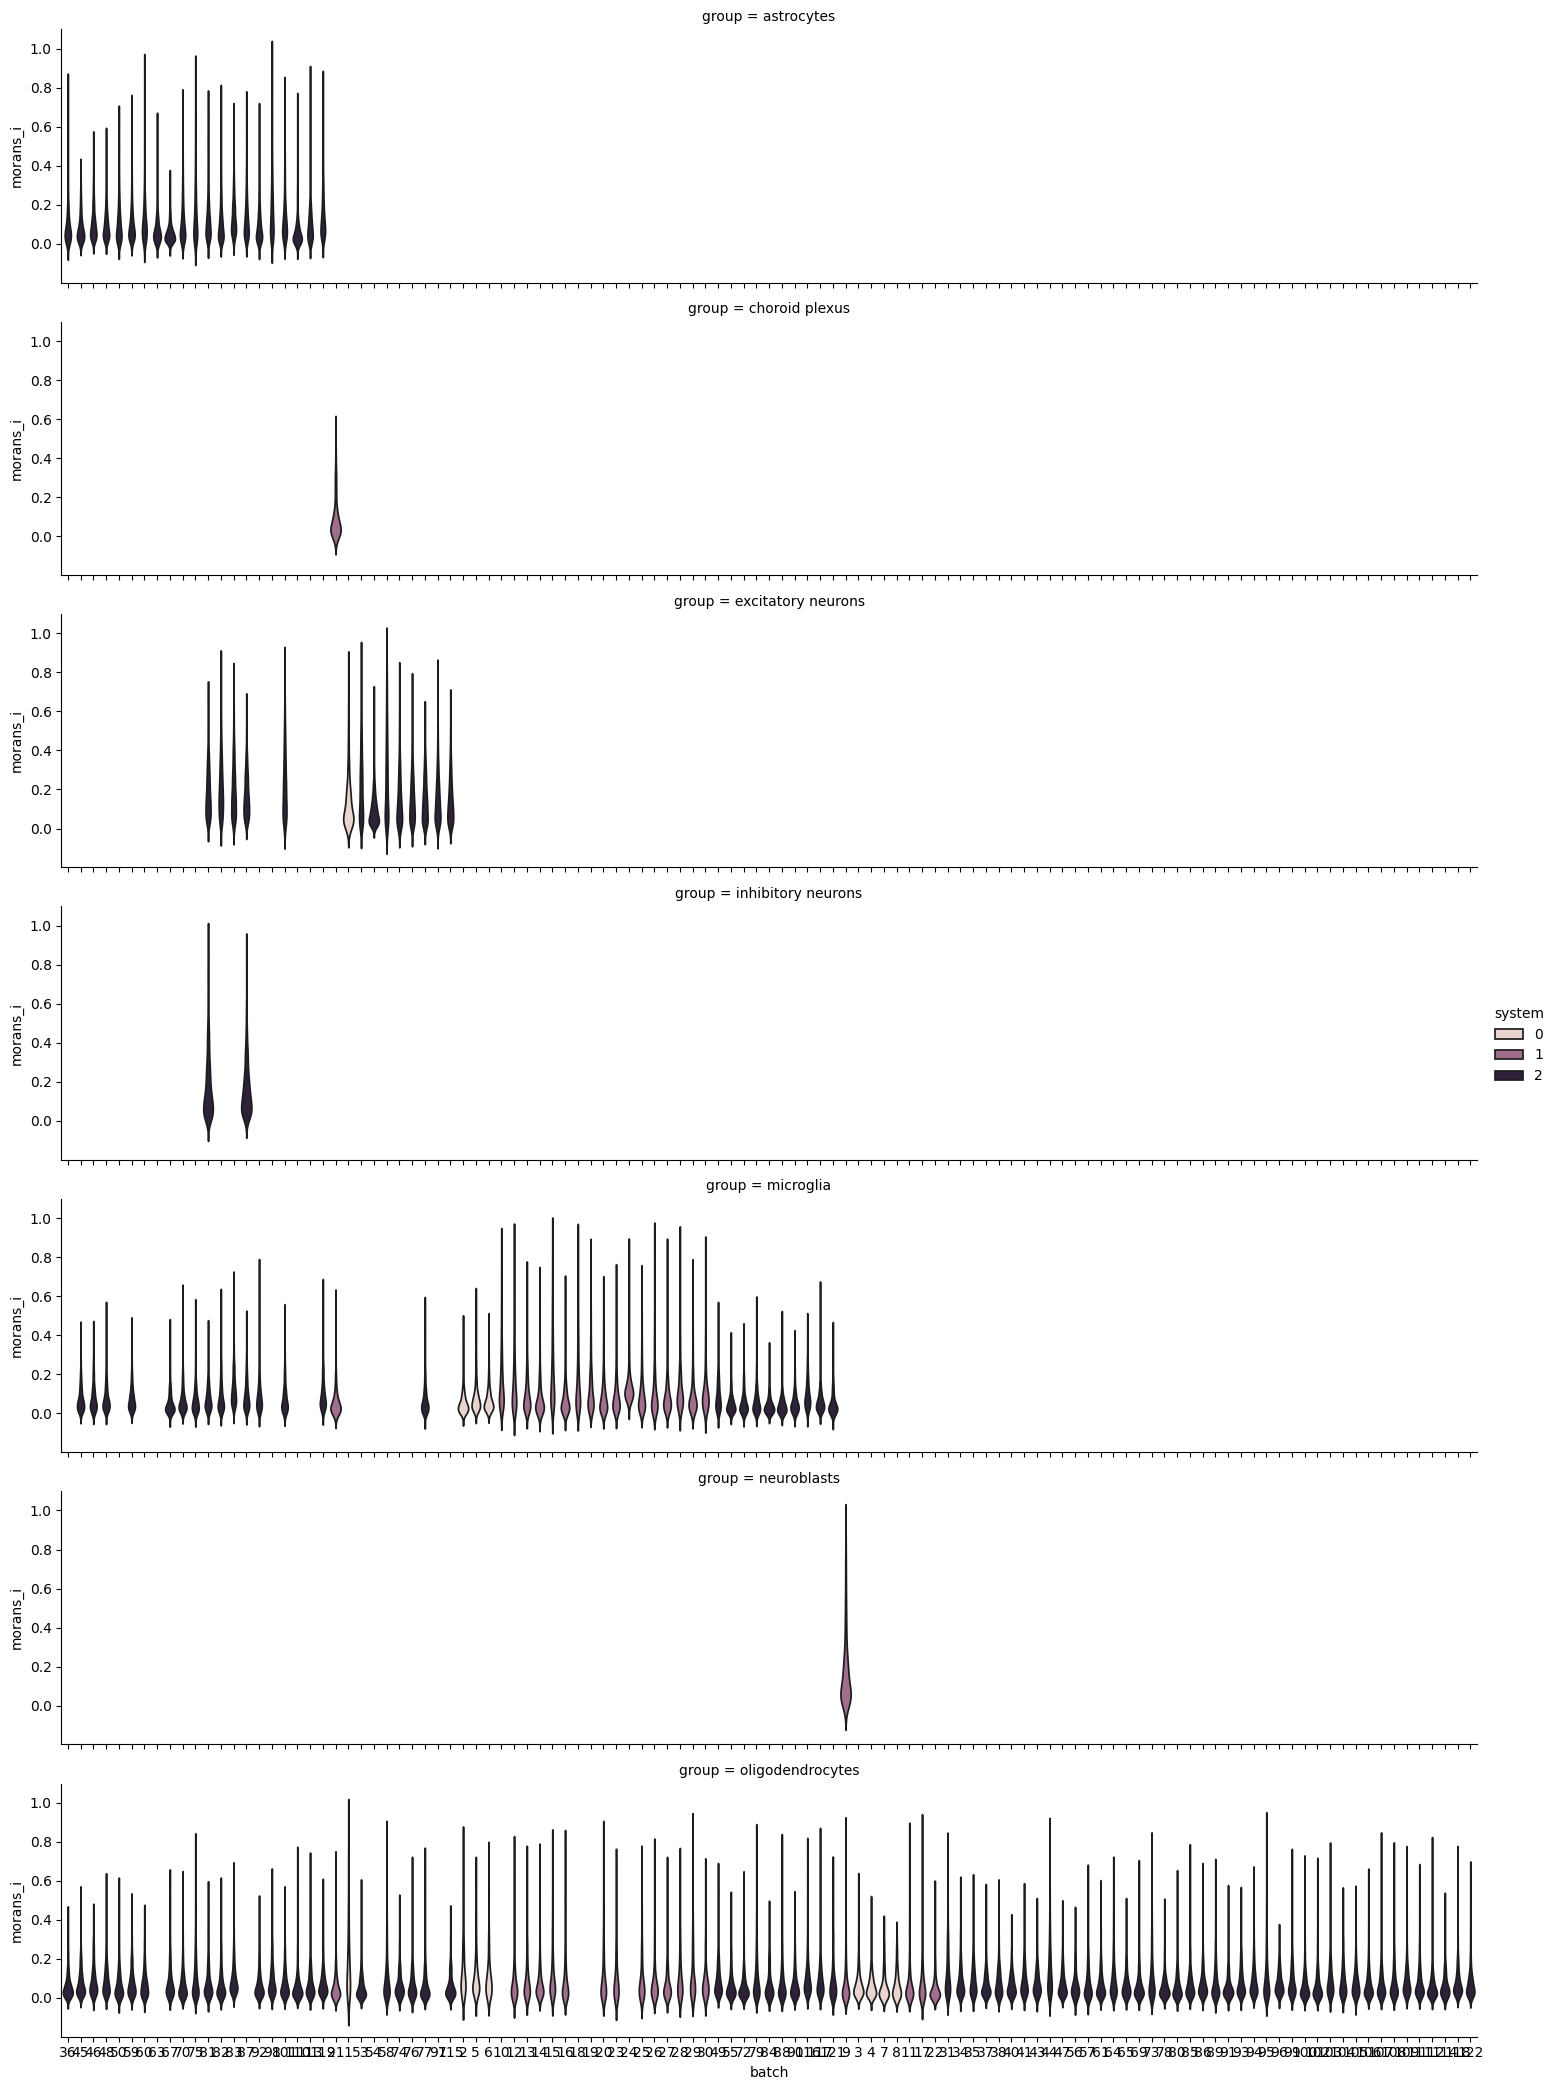

In [14]:
# Moran's I distn accross groups
sb.catplot(x='batch',y='morans_i',hue='system',row='group',data=data,kind='violin',
           inner=None,height=3,aspect=5)

In [15]:
# I thr
thr_mi=0.2

In [16]:
# N genes per group at certain thr
rows=pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 250)
display(data.groupby(['group','system','batch']).apply(lambda x: (x['morans_i']>=thr_mi).sum()))
pd.set_option('display.max_rows', rows)

/tmp/143724.1.gpu-long/ipykernel_2395080/2995334106.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display(data.groupby(['group','system','batch']).apply(lambda x: (x['morans_i']>=thr_mi).sum()))


group               system  batch
astrocytes          2       101      344
                            110       70
                            113      216
                            119      399
                            36       109
                            45       125
                            46       206
                            48       212
                            50       286
                            59       189
                            60       325
                            63        63
                            67        12
                            70       302
                            75       517
                            81       245
                            82       266
                            83       330
                            87       294
                            92       235
                            98       282
choroid plexus      1       21        39
excitatory neurons  0       1        199
                    2  

/tmp/143724.1.gpu-long/ipykernel_2395080/1885998139.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  [data.groupby(['group','system','batch']).apply(lambda x: (x['morans_i']>=thr_mi).sum()).rename('N genes'),


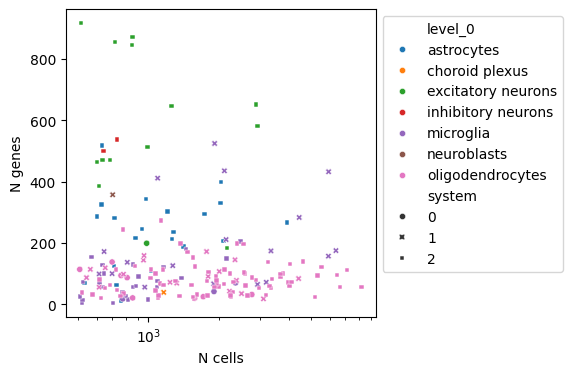

In [17]:
# N genes vs N cells in group
rcParams['figure.figsize']=(4,4)
sb.scatterplot(x='N cells',y='N genes',hue='level_0',style='system',
           data=pd.concat(
    [data.groupby(['group','system','batch']).apply(lambda x: (x['morans_i']>=thr_mi).sum()).rename('N genes'),
    groups.rename('N cells')],axis=1).reset_index(),s=20)
plt.legend(bbox_to_anchor=(1,1))
plt.xscale('log')

# Batch effects within and between

In [35]:
adata

AnnData object with n_obs × n_vars = 433583 × 2904
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'human_gene_id', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name'
    layers: 'counts', 'log1p_norm'

In [33]:
adata.obs

,sample_id,publication,sample_id_anon,individual_id_anon,replicate,treatment,condition,tissue,time,batch,lesion_type,sample_source,diagnosis,n_genes_by_counts,total_counts,pct_counts_mt,pct_counts_ribo,s_score,g2m_score,phase,type_fine,type_broad,cluster_zoom,exclude_pseudobulk,seq_pool,sex,age_at_death,smoker,cause_of_death,years_w_ms,pmi_minutes,age_scale,age_cat,pmi_cat,pmi_cat2,cell_cycle_diff,cell_type_eval,library_type,sample_type,organism,system
GTATTTCGTCCACATA-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,3806.0,14894.0,0.013428,0.093998,-0.160523,-0.120577,G1,TBD,excitatory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,-0.039946,excitatory neurons,10X 3p kit v3.1,sn,mouse,0
ATACCTTGTCGACGCT-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,3755.0,14716.0,0.000000,0.176678,-0.137565,-0.107280,G1,TBD,inhibitory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,-0.030285,inhibitory neurons,10X 3p kit v3.1,sn,mouse,0
TCAAGACGTGCTGCAC-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,4396.0,14823.0,0.026985,0.155164,-0.147916,-0.150035,G1,TBD,excitatory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,0.002119,excitatory neurons,10X 3p kit v3.1,sn,mouse,0
AGTACTGTCAAGTAAG-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,4583.0,14604.0,0.020542,0.212271,-0.132352,-0.172023,G1,TBD,excitatory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,0.039672,excitatory neurons,10X 3p kit v3.1,sn,mouse,0
TCCCAGTTCCGATGCG-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,3839.0,14266.0,0.028039,0.203281,-0.134222,-0.118009,G1,TBD,inhibitory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,-0.016213,inhibitory neurons,10X 3p kit v3.1,sn,mouse,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ind102-Sample4:TTTGTTGAGCGACTGA-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,CAL,Amsterdam BB,SPMS,842.0,1227.0,5.207486,0.437056,0.006362,-0.053391,S,Oligo_B,Oligodendrocytes,oligo_opc-cl01,False,Pool 1,M,64,non-smoker,terminal phase ms; spastic ms,34.0,450.0,0.301502181578831,inbetween,6H_to_12H,up_to_12H,0.059753,oligodendrocytes,10X 3p kit v3.3,sn,human,2
Ind102-Sample4:TTTGTTGAGTAGCTCT-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,CAL,Amsterdam BB,SPMS,641.0,1060.0,7.627119,0.139768,-0.048246,-0.086150,G1,Micro_C,Microglia,microglia-cl03,False,Pool 1,M,64,non-smoker,terminal phase ms; spastic ms,34.0,450.0,0.301502181578831,inbetween,6H_to_12H,up_to_12H,0.037903,microglia,10X 3p kit v3.3,sn,human,2
Ind102-Sample4:TTTGTTGCAGACGATG-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,CAL,Amsterdam BB,SPMS,580.0,820.0,7.299270,0.322318,-0.084481,-0.032177,G1,Micro_B,Microglia,microglia-cl02,False,Pool 1,M,64,non-smoker,terminal phase ms; spastic ms,34.0,450.0,0.301502181578831,inbetween,6H_to_12H,up_to_12H,-0.052304,microglia,10X 3p kit v3.3,sn,human,2
Ind102-Sample4:TTTGTTGCATACAGAA-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,CAL,Amsterdam BB,SPMS,1146.0,1899.0,5.891636,0.383352,0.025758,0.049047,G2M,Oligo_E,Oligodendrocytes,oligo_opc-cl03,False,Pool 1,M,64,non-smoker,terminal 

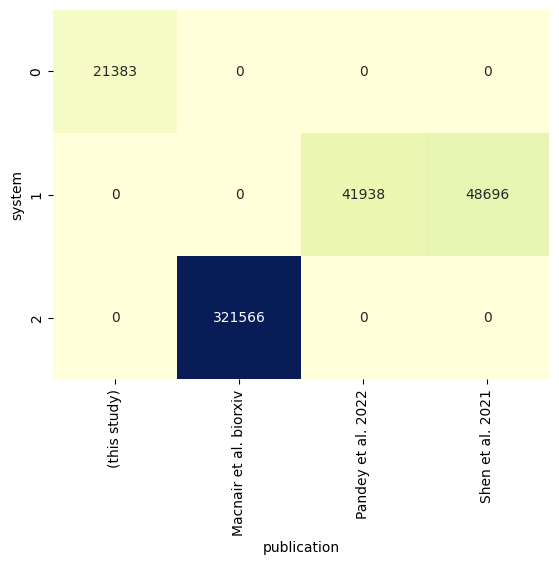

In [34]:
crosstab_df = pd.crosstab(adata.obs.system, adata.obs.publication)

# Create the heatmap with integer annotations
sb.heatmap(crosstab_df, cmap="YlGnBu", annot=True, fmt="d", cbar=False)

# Show the heatmap
plt.show()

In [5]:
unique_publications = adata.obs['publication'].unique()
print("Unique publications:", unique_publications)

Unique publications: ['(this study)', 'Pandey et al. 2022', 'Shen et al. 2021', 'Macnair et al. biorxiv']
Categories (4, object): ['(this study)', 'Macnair et al. biorxiv', 'Pandey et al. 2022', 'Shen et al. 2021']


In [6]:
unique_sys = adata.obs['system'].unique()
print("Unique systems:", unique_sys)

Unique systems: [0 1 2]


In [7]:
# Compute PCA on the whole data
adata_scl=adata.copy()
sc.pp.scale(adata_scl)
n_pcs=15
sc.pp.pca(adata_scl, n_comps=n_pcs)
pca=pd.DataFrame(adata_scl.obsm['X_pca'],index=adata_scl.obs_names)
del adata_scl

In [ ]:
adata.obs["mm_study"] = 

In [36]:
# Average PCA accross system-batch-group pseudobulks. 
# Only use pseudobulks with at least 50 cells
# Only use cell types with at least 3 samples per system
pca[['system','mm_study','batch','group']]=adata.obs[['system', 'system','batch', 'cell_type_eval']]
#pca['mm_study']=pca['mm_study'].cat.add_categories('hs').fillna('hs')
pca_pb=pca.groupby(['system','study','batch','group'])
pca_mean=pca_pb.mean()
pb_size=pca_pb.size()
# Remove samples with too little cells
filtered_pb=pb_size.index[pb_size>=50]
# Get pbs/cts where both systems have enough samples
n_samples_system=filtered_pb.to_frame().rename({'group':'group_col'},axis=1).groupby(
    'group_col',observed=True)['system'].value_counts().rename('n_samples').reset_index()
cts=set(n_samples_system.query('system==0 & n_samples>=3').group_col)&\
    set(n_samples_system.query('system==1 & n_samples>=3').group_col)&\
    set(n_samples_system.query('system==2 & n_samples>=3').group_col)
filtered_pb=filtered_pb[filtered_pb.get_level_values(3).isin(cts)]
pca_mean=pca_mean.loc[filtered_pb,:]

ValueError: Columns must be same length as key

In [37]:
filtered_pb

MultiIndex([(0,           '(this study)',   '1',        'microglia'),
            (0,           '(this study)',   '1', 'oligodendrocytes'),
            (0,           '(this study)',   '1',      'opcs + cops'),
            (0,           '(this study)',   '2',       'astrocytes'),
            (0,           '(this study)',   '2',        'microglia'),
            (0,           '(this study)',   '2', 'oligodendrocytes'),
            (0,           '(this study)',   '2',      'opcs + cops'),
            (0,           '(this study)',   '3',       'astrocytes'),
            (0,           '(this study)',   '3',        'microglia'),
            (0,           '(this study)',   '3', 'oligodendrocytes'),
            ...
            (2, 'Macnair et al. biorxiv', '119',      'opcs + cops'),
            (2, 'Macnair et al. biorxiv', '120', 'oligodendrocytes'),
            (2, 'Macnair et al. biorxiv', '121',       'astrocytes'),
            (2, 'Macnair et al. biorxiv', '121',        'microglia'),
    

In [38]:
# Compute per-ct distances of samples within and between systems
distances={}
for ct in cts:
    # Data for computing distances
    pca_s0=pca_mean[(pca_mean.index.get_level_values(0)==0) &
                    (pca_mean.index.get_level_values(3)==ct)]
    pca_s1=pca_mean[(pca_mean.index.get_level_values(0)==1) &
                    (pca_mean.index.get_level_values(3)==ct)]
    
    # Distances for s0 - within or between datasets
    d_s0=euclidean_distances(pca_s0)
    triu=np.triu_indices(pca_s0.shape[0],k=1)
    idx_map=dict(enumerate(pca_s0.index.get_level_values(1)))
    idx_within=([],[])
    idx_between=([],[])
    for i,j in zip(*triu):
        if idx_map[i]==idx_map[j]:
            idx_list=idx_within
        else:
            idx_list=idx_between
        idx_list[0].append(i)
        idx_list[1].append(j)
    d_s0_within=d_s0[idx_within]
    d_s0_between=d_s0[idx_between]
    
    # Distances for s1 and s0s1
    d_s1=euclidean_distances(pca_s1)[np.triu_indices(pca_s1.shape[0],k=1)]
    d_s0s1=euclidean_distances(pca_s0,pca_s1).ravel()
    distances[ct]={'s0_within':d_s0_within,'s0_between':d_s0_between,'s1':d_s1,'s0s1':d_s0s1}

In [39]:
plot = []
for ct, dat in distances.items():
    for comparison, dist in dat.items():
        dist = pd.DataFrame(dist, columns=['dist'])
        dist['group'] = ct
        dist['comparison'] = comparison
        plot.append(dist)
        
        # Check if the comparison is 's0_between'
        # If yes, ensure it's included in the DataFrame even if it's empty
        if comparison == 's0_between' and dist.empty:
            empty_df = pd.DataFrame(columns=['dist', 'group', 'comparison'])
            empty_df['group'] = ct
            empty_df['comparison'] = comparison
            plot.append(empty_df)

plot = pd.concat(plot)

/tmp/143724.1.gpu-long/ipykernel_2402350/1513747399.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot = pd.concat(plot)


/tmp/143724.1.gpu-long/ipykernel_2402350/1591975774.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.catplot(x='comparison', y='dist', col='group',


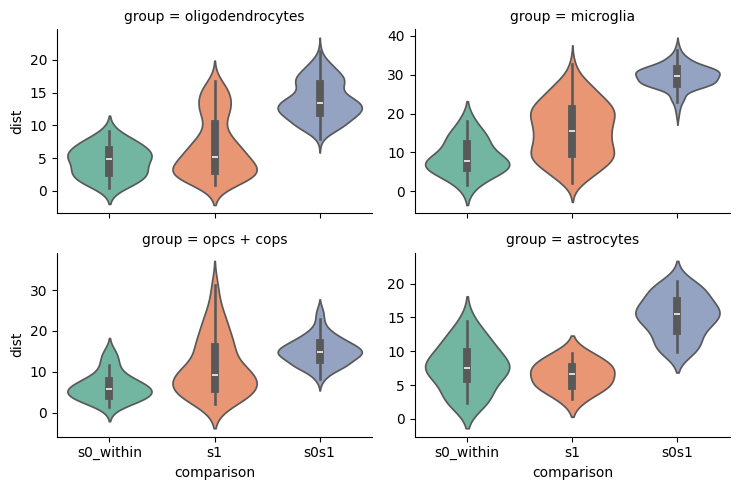

In [40]:
# Plot distances
sb.catplot(x='comparison', y='dist', col='group',
           data=plot.reset_index(drop=True), kind='violin',
           sharey=False, height=2.5, aspect=1.5, col_wrap=2,
           palette='Set2')

In [12]:
# Compute significance of differences within and accross systems
signif=[]
for ct,dat in distances.items():
    for ref in ['s0_within','s0_between','s1']:
        n_system=dat[ref].shape[0]
        if n_system>=3:
            u,p=mannwhitneyu( dat[ref],dat['s0s1'],alternative='less')
            signif.append(dict( cell_type=ct,system=ref, u=u,pval=p,
                               n_system=n_system,n_crossystem=dat['s0s1'].shape[0]))
signif=pd.DataFrame(signif)
signif['padj']=multipletests(signif['pval'],method='fdr_bh')[1]

In [13]:
signif

,cell_type,system,u,pval,n_system,n_crossystem,padj
0,opcs + cops,s0_within,130.0,8.023803e-14,28,104,2.005951e-13
1,opcs + cops,s1,2315.0,3.739038e-07,78,104,4.673798e-07
2,astrocytes,s0_within,37.0,1.168476e-08,21,35,1.947460e-08
3,astrocytes,s1,0.0,9.488921e-07,10,35,9.488921e-07
4,microglia,s0_within,0.0,1.345210e-10,15,126,2.690420e-10
5,microglia,s1,917.0,1.391594e-46,210,126,1.391594e-45
6,oligodendrocytes,s0_within,3.0,1.124863e-17,28,176,3.749543e-17
7,oligodendrocytes,s1,5139.0,1.769181e-38,231,176,8.845906e-38
8,neuroblasts,s0_within,0.0,7.435475e-07,6,28,8.261639e-07
9,neuroblasts,s1,33.0,7.090238e-08,21,28,1.012891e-07


/tmp/143724.1.gpu-long/ipykernel_2402350/495748581.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.catplot(x='comparison', y='dist', col='group',


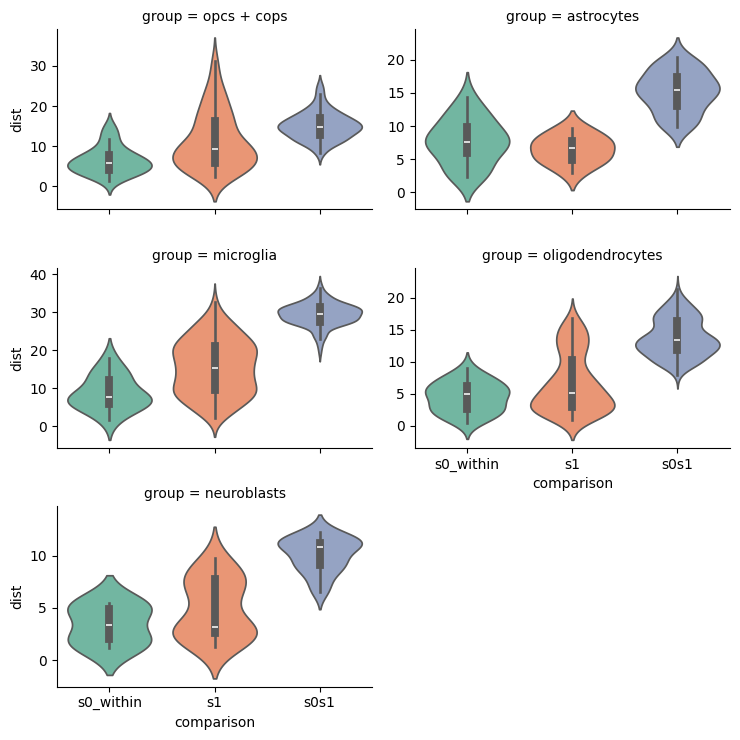

In [16]:
plot = []
for ct, dat in distances.items():
    for comparison in ['s0_within', 's0_between', 's1', 's0s1']:  # Ensure all comparisons are included
        dist = dat.get(comparison, [])  # Get the distances for the comparison, or an empty list if it's missing
        dist = pd.DataFrame(dist, columns=['dist'])
        dist['group'] = ct
        dist['comparison'] = comparison
        plot.append(dist)

plot = pd.concat(plot)

# Plot distances
sb.catplot(x='comparison', y='dist', col='group',
           data=plot.reset_index(drop=True), kind='violin',
           sharey=False, height=2.5, aspect=1.5, col_wrap=2,
           palette='Set2')